# Анализ результатов AB тестирования

Датасет взят с
- https://www.kaggle.com/datasets/putdejudomthai/ecommerce-ab-testing-2022-dataset1

Описание датасета:

В этом проекте вы будете работать над тем, чтобы понять результаты A/B-тестирования, проводимого веб-сайтом электронной коммерции.
Компания разработала новую веб-страницу для того, чтобы попытаться увеличить количество пользователей, которые конвертируются в покупателей. Ваша цель состоит в том, чтобы проанализировать данные, чтобы помочь компании понять, следует ли им внедрить новую страницу, сохранить старую страницу или, возможно, провести эксперимент дольше, чтобы принять решение.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
df = pd.read_csv('ab_data.csv', sep=',', encoding='utf-8')
print(df.shape)

(294480, 5)


In [3]:
countries = pd.read_csv('countries.csv', sep=',', encoding='utf-8')
print(countries.shape)

(290586, 2)


## EDA:

**Избавимся от дубликатов**

In [4]:
countries.drop_duplicates(inplace=True)
df.drop_duplicates(inplace=True)

In [5]:
df.head(3)

,user_id,timestamp,group,landing_page,converted
0,851104,11:48.6,control,old_page,0
1,804228,01:45.2,control,old_page,0
2,661590,55:06.2,treatment,new_page,0


In [6]:
countries.head(3)

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294480 entries, 0 to 294479
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294480 non-null  int64 
 1   timestamp     294480 non-null  object
 2   group         294480 non-null  object
 3   landing_page  294480 non-null  object
 4   converted     294480 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


In [8]:
countries.info()

<class 'pandas.core.frame.DataFrame'>
Index: 290585 entries, 0 to 290585
Data columns (total 2 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   user_id  290585 non-null  int64 
 1   country  290585 non-null  object
dtypes: int64(1), object(1)
memory usage: 6.7+ MB


**Найдем пользователей, которые встречаются несколько раз**

In [9]:
df1 = df.user_id.value_counts()
df1.head(3)

user_id
712134    2
684144    2
783176    2
Name: count, dtype: int64

In [10]:
df1.max()

2

**Некоторые пользователи встречаются 2 раза, выясним, почему так происходит**

In [11]:
arr1 = df1[df1 > 1].index
df[df.user_id.isin(arr1)].sort_values('user_id').head(8)

,user_id,timestamp,group,landing_page,converted
213114,630052,25:54.1,treatment,old_page,1
230259,630052,16:05.2,treatment,new_page,0
22513,630126,35:54.8,treatment,old_page,0
251762,630126,16:00.3,treatment,new_page,0
183371,630137,08:49.9,control,old_page,0
11792,630137,59:22.1,control,new_page,0
207211,630320,02:43.6,control,old_page,0
255753,630320,27:37.2,treatment,old_page,0


**Контрольной группе должна показываться старая версия страницы, а экспериментальной - новая,
но у нас есть пользователи, которые продублировались и возникли сочетания:**
* *treatment - old_page* 
* *control - new_page*

In [12]:
pd.crosstab(df['group'], df['landing_page'])

landing_page,new_page,old_page
group,,
control,1928,145274
treatment,145313,1965


Очистим таблицу от этих данных

In [13]:
cleaned_df = df[~((df['group'] == 'treatment') & (df['landing_page'] == 'old_page')) &\
               ~((df['group'] == 'control') & (df['landing_page'] == 'new_page'))]

In [14]:
pd.crosstab(cleaned_df['group'], cleaned_df['landing_page'])

landing_page,new_page,old_page
group,,
control,0,145274
treatment,145313,0


In [15]:
res_df = cleaned_df.merge(countries, how='left', on='user_id')

In [16]:
res_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290587 entries, 0 to 290586
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       290587 non-null  int64 
 1   timestamp     290587 non-null  object
 2   group         290587 non-null  object
 3   landing_page  290587 non-null  object
 4   converted     290587 non-null  int64 
 5   country       290587 non-null  object
dtypes: int64(2), object(4)
memory usage: 13.3+ MB


### Посмотрим, как пользователи из тестовой и контрольной группы распределены по старанам

In [17]:
region_df = res_df.groupby(['group', 'country']).agg(users_count=('country', 'count'), conversion=('converted', 'mean'))
region_df

users_count  conversion
group     country                         
control   CA              7198    0.118783
          UK             36360    0.120022
          US            101716    0.120630
treatment CA              7301    0.111902
          UK             36106    0.121171
          US            101906    0.118462

In [18]:
region_df = region_df.reset_index()

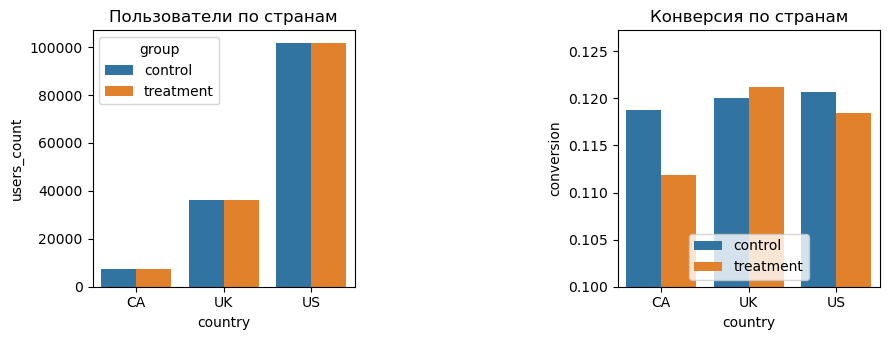

In [19]:
fig, axes = plt.subplots(1, 2, figsize=(9, 3.5))

sns.barplot(region_df, x='country', y='users_count', hue='group', ax=axes[0])
axes[0].set_title('Пользователи по странам')
sns.barplot(region_df, x='country', y='conversion', hue='group', ax=axes[1])
axes[1].legend(loc='lower center')
axes[1].set_title('Конверсия по странам')
axes[1].set_ylim(0.1)

plt.tight_layout()
fig.subplots_adjust(wspace=1)
plt.show()

**Пользователи равномерно разделены по странам, рассчитаем теперь конверсию для тестовой и контрольной группы**

In [20]:
conv = res_df.groupby('group', as_index=False).agg(conversion=('converted', 'mean'))
conv

,group,conversion
0,control,0.120386
1,treatment,0.118806


Проверим, есть ли статистически значимые различия в конверсии

### Z тест для пропорций:

**Сформулируем гипотезы**

* H0: конверсия в контрольной группе равна конверсии в экспериментальной 
* H1: конверсии различаются


**Выберем уровень значимости a = 0.05**

In [21]:
a = 0.05

**Рассчитаем число успешых *k* и общее число *n* испытаний в обеих группах**

In [22]:
count_df = res_df.groupby('group').agg(k=('converted', 'sum'), n=('converted', 'count'))
count_df

,k,n
group,,
control,17489,145274
treatment,17264,145313


In [23]:
k_control = count_df.loc['control', 'k']
k_treatment = count_df.loc['treatment', 'k']
n_control = count_df.loc['control', 'n']
n_treatment = count_df.loc['treatment', 'n']

**Рассчитаем Z статистику**

In [24]:
from scipy import stats
#cr - conversion rate

cr_control = conv.loc[0, 'conversion']  # конверсия в контрольной группе
cr_treatment = conv.loc[1, 'conversion']  # Конверсия в тестовой группе

# Рассчитаем Z статистику
Z = (cr_control - cr_treatment) / np.sqrt(cr_control*(1-cr_control) / n_control + cr_treatment * (1-cr_treatment) / n_treatment)

**Найдем p_value**

In [25]:
# cdf(x): вероятность того, что случайная величина примет значение меньшее или равное x

p_value = 2 * (1 - stats.norm.cdf(np.abs(Z)))

In [26]:
print(f'Уровень значимости: {a}')
print(f'Z-статистика: {Z:.3f}')
if p_value < 0.05:
    print(f'p-value: {p_value:.3f}. \nОтклоняем нулевую гипотезу')
elif p_value >= 0.05:
    print(f'p-value: {p_value:.3f}. \nНет оснований отклонить нулевую гипотезу')
else:
    print('Проверьте корректность данных')

Уровень значимости: 0.05
Z-статистика: 1.313
p-value: 0.189. 
Нет оснований отклонить нулевую гипотезу


- Проверим результат

In [27]:
from statsmodels.stats.proportion import proportions_ztest

stat, p_value = proportions_ztest([k_control, k_treatment], [n_control, n_treatment])
print(f"Z-статистика = {stat:.3f}\np-value = {p_value:.3f}")

Z-статистика = 1.313
p-value = 0.189


### На данный момент у нас нет оснований предполагать, что конверсия изменилась, посмотрим достаточная ли мощность у теста

In [28]:
from statsmodels.stats.power import NormalIndPower
from statsmodels.stats.proportion import proportion_effectsize

# Размер эффекта 
effect_size = proportion_effectsize(cr_control, cr_treatment)

# Расчет мощности
power_analysis = NormalIndPower()
power = power_analysis.power(
    effect_size=effect_size,
    nobs1=n_control,
    alpha=0.05,
    ratio= n_treatment/n_control
)

In [29]:
print(f'Мощность теста: {round(power * 100)}%')

Мощность теста: 26%


 **Мощность получилась слишком низкая. Высока вероятность не зафиксировать эффект, если он действительно есть.**

 **Эксперимент стоит проводить дальше**

---

### * Проанализируем время сесси

In [30]:
res_df.head(3)

,user_id,timestamp,group,landing_page,converted,country
0,851104,11:48.6,control,old_page,0,US
1,804228,01:45.2,control,old_page,0,US
2,661590,55:06.2,treatment,new_page,0,US


In [31]:
print(res_df.timestamp.dtypes)

object


In [32]:
# переведем вреям в секунды
def to_sec(time):
    minutes, sec = time.split(':')
    return int(minutes) * 60 + float(sec)

res_df['sec'] = res_df.timestamp.apply(to_sec)

In [33]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

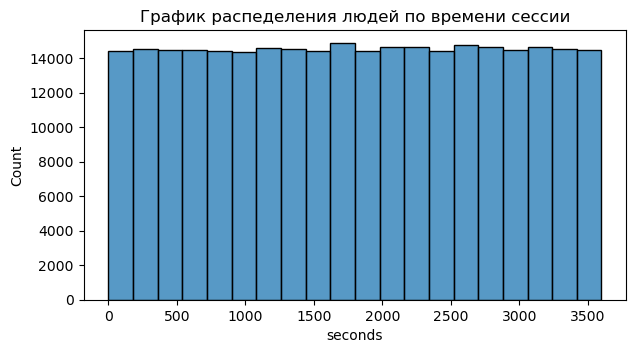

In [34]:
plt.figure(figsize=(7, 3.5))
sns.histplot(res_df, x='sec', bins=20)
plt.xlabel('seconds')
plt.title('График распеделения людей по времени сессии')
plt.show()

In [35]:
(res_df.sec / 60).max()

59.998333333333335

In [36]:
intervals = [
    "до 10 минут",
    "10-20 минут",
    "20-30 минут", 
    "30-40 минут",
    "40-50 минут",
    "50-60 минут"
]
res_df['time_intervals'] = pd.cut(res_df['sec'] / 60, bins=6, labels=intervals)

In [37]:
res_df.head()

,user_id,timestamp,group,landing_page,converted,country,sec,time_intervals
0,851104,11:48.6,control,old_page,0,US,708.6,10-20 минут
1,804228,01:45.2,control,old_page,0,US,105.2,до 10 минут
2,661590,55:06.2,treatment,new_page,0,US,3306.2,50-60 минут
3,853541,28:03.1,treatment,new_page,0,US,1683.1,20-30 минут
4,864975,52:26.2,control,old_page,1,US,3146.2,50-60 минут


рассчитаем конверсию в разных временных интервалах

In [38]:
intervals_df = res_df.groupby(['group', 'time_intervals'], as_index=False).agg(conversion=('converted', 'mean'))

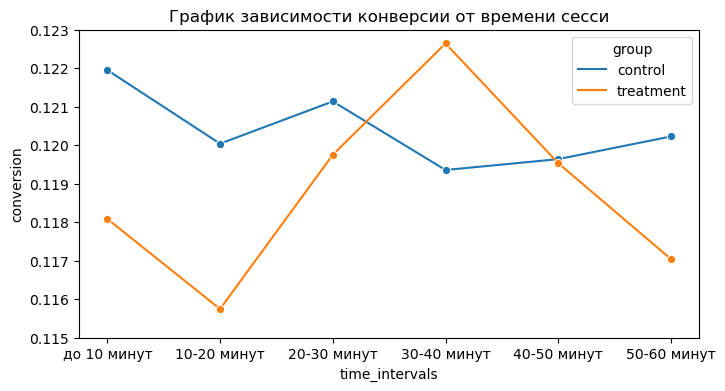

In [39]:
plt.figure(figsize=(8, 4))
sns.lineplot(intervals_df, x='time_intervals', y='conversion', hue='group', marker='o')

plt.ylim(0.115, 0.123)
plt.title('График зависимости конверсии от времени сесси')
plt.show()

## Выводы:

**Был проведён разведочный анализ данных *(EDA)***:
- Удалены дубликаты
- построены графики:
- - распределения пользователей по странам
- - конверсии по странам
- а также графики:
- - распределения кол-ва людей в зависимости от времени сесси 
- - конверсии в зависимости от времени сессии.

---
**Была проверена гипотеза (H0) о том, что в результате внедрения новой версии веб сраницы конверсия не изменилась.**

- На основании полученного *p-value = 0.189* у нас нет оснований отвергнуть гипотезу о равенстве конверсий в тестовой и контрольной группе при   *уровне значимости = 0.05*.

- Но тест имеет недостаточную мощность для принятия решений. Высока вероятность не обнаружить эффект, если он есть, поэтому **следует продолжить наблюдения**.  
